In [1]:
import os
from os import listdir
from os.path import join, dirname
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys

PATH_REPO = dirname(os.getcwd())
PATH_DATA = join(PATH_REPO, 'data')
PATH_UTILS = join(PATH_REPO, 'src')
sys.path.append(PATH_UTILS)

import preprocess

### Load Data

In [2]:
data = pd.read_csv(join(PATH_DATA, 'Train.csv'))
data_format = preprocess.format_data(data)

In [3]:
indexes_missing_values = data_format['stock_distributed'].isnull()

### Fill Nan

In [4]:
data_format = preprocess.replaceNAv0(data_format)

In [5]:
#data_format.loc[] = data_format.loc[0,].fillna(0)
for i in range(1,4):
      data_format['stock_distributed_monthlag'+'{}'.format(i)] = data_format.groupby(['site_code', 'product_code'])['stock_distributed'].shift(i)


In [6]:
TRAIN_START_MONTH = '2016-04-01' # Train Data Using Data 6 Months after the First Data Recorded
TRAIN_END_MONTH = '2019-03-01'

TEST_START_MONTH = '2019-04-01' # Test Data Using Last 2 Month Data
TEST_END_MONTH = '2019-06-01'

FEATURES = ['stock_distributed_monthlag1', 'stock_distributed_monthlag2', 'stock_distributed_monthlag3']
TARGET = ['stock_distributed']

CATEGORICAL_VARIABLES = ['product_code', 'site_code', 'service_type', 'product_type']

In [7]:
from datetime import datetime

train = data_format.loc[(data_format.loc[:,'date']>=datetime.strptime(TRAIN_START_MONTH, '%Y-%m-%d')) & \
             (data_format.loc[:,'date']<=datetime.strptime(TRAIN_END_MONTH, '%Y-%m-%d')), FEATURES + TARGET + CATEGORICAL_VARIABLES]


val = data_format.loc[(data_format.loc[:,'date']>=datetime.strptime(TEST_START_MONTH, '%Y-%m-%d')) & \
             (data_format.loc[:,'date']<=datetime.strptime(TEST_END_MONTH, '%Y-%m-%d')), FEATURES+ TARGET + CATEGORICAL_VARIABLES]


## Model


In [8]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor



X_train = train[FEATURES+CATEGORICAL_VARIABLES]
y_train = train[TARGET]


X_val = val[FEATURES+CATEGORICAL_VARIABLES]
y_val = val[TARGET]

# Create the preprocessing transformers
cat_transformer = OneHotEncoder()
num_transformer = StandardScaler()

# Create the column transformer
preprocessor = ColumnTransformer([
    ('cat', cat_transformer, CATEGORICAL_VARIABLES),
    ('num', num_transformer, FEATURES)
])

# Create the pipeline

models = {}

models['LR'] = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

models['RFR'] = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

models['GBR'] = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())
])



# Fit the pipeline
for name, reg in models.items():
    reg.fit(X_train, y_train['stock_distributed'].values)


In [9]:
X_val_nona = X_val.loc[indexes_missing_values[66495:]==False,]
y_val_nona = y_val.loc[indexes_missing_values[66495:]==False,]

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, median_absolute_error, explained_variance_score, max_error


for name, reg in models.items():
    print(f'Metrics for {name}')
    for metric in [mean_squared_error, mean_absolute_percentage_error, median_absolute_error, explained_variance_score, max_error]:
        print(f'{metric(y_val_nona["stock_distributed"].values, reg.predict(X_val_nona))}')

Metrics for LR
556.1921478496806
9975437805134562.0
4.088311357782641
0.5617361422938912
325.41345525782305
Metrics for RFR
650.646637160992
8879765284155205.0
2.903238095238095
0.4866179991911298
378.73
Metrics for GBR
583.2956217759817
8329231405028054.0
2.949903042008751
0.5387553932193108
330.46934911762986


Fill with 0's

Metrics for LR
396.17475613493343
1.0450652877929012e+16
2.6752254147934007
0.5287712933330769
429.5985389409383
Metrics for RFR
415.5197483945364
5662933544153001.0
0.18480565819207853
0.5056275430101405
456.805
Metrics for GBR
361.25437315998767
6881963184451513.0
1.132413227530893
0.5691785254188555
427.60592257870206

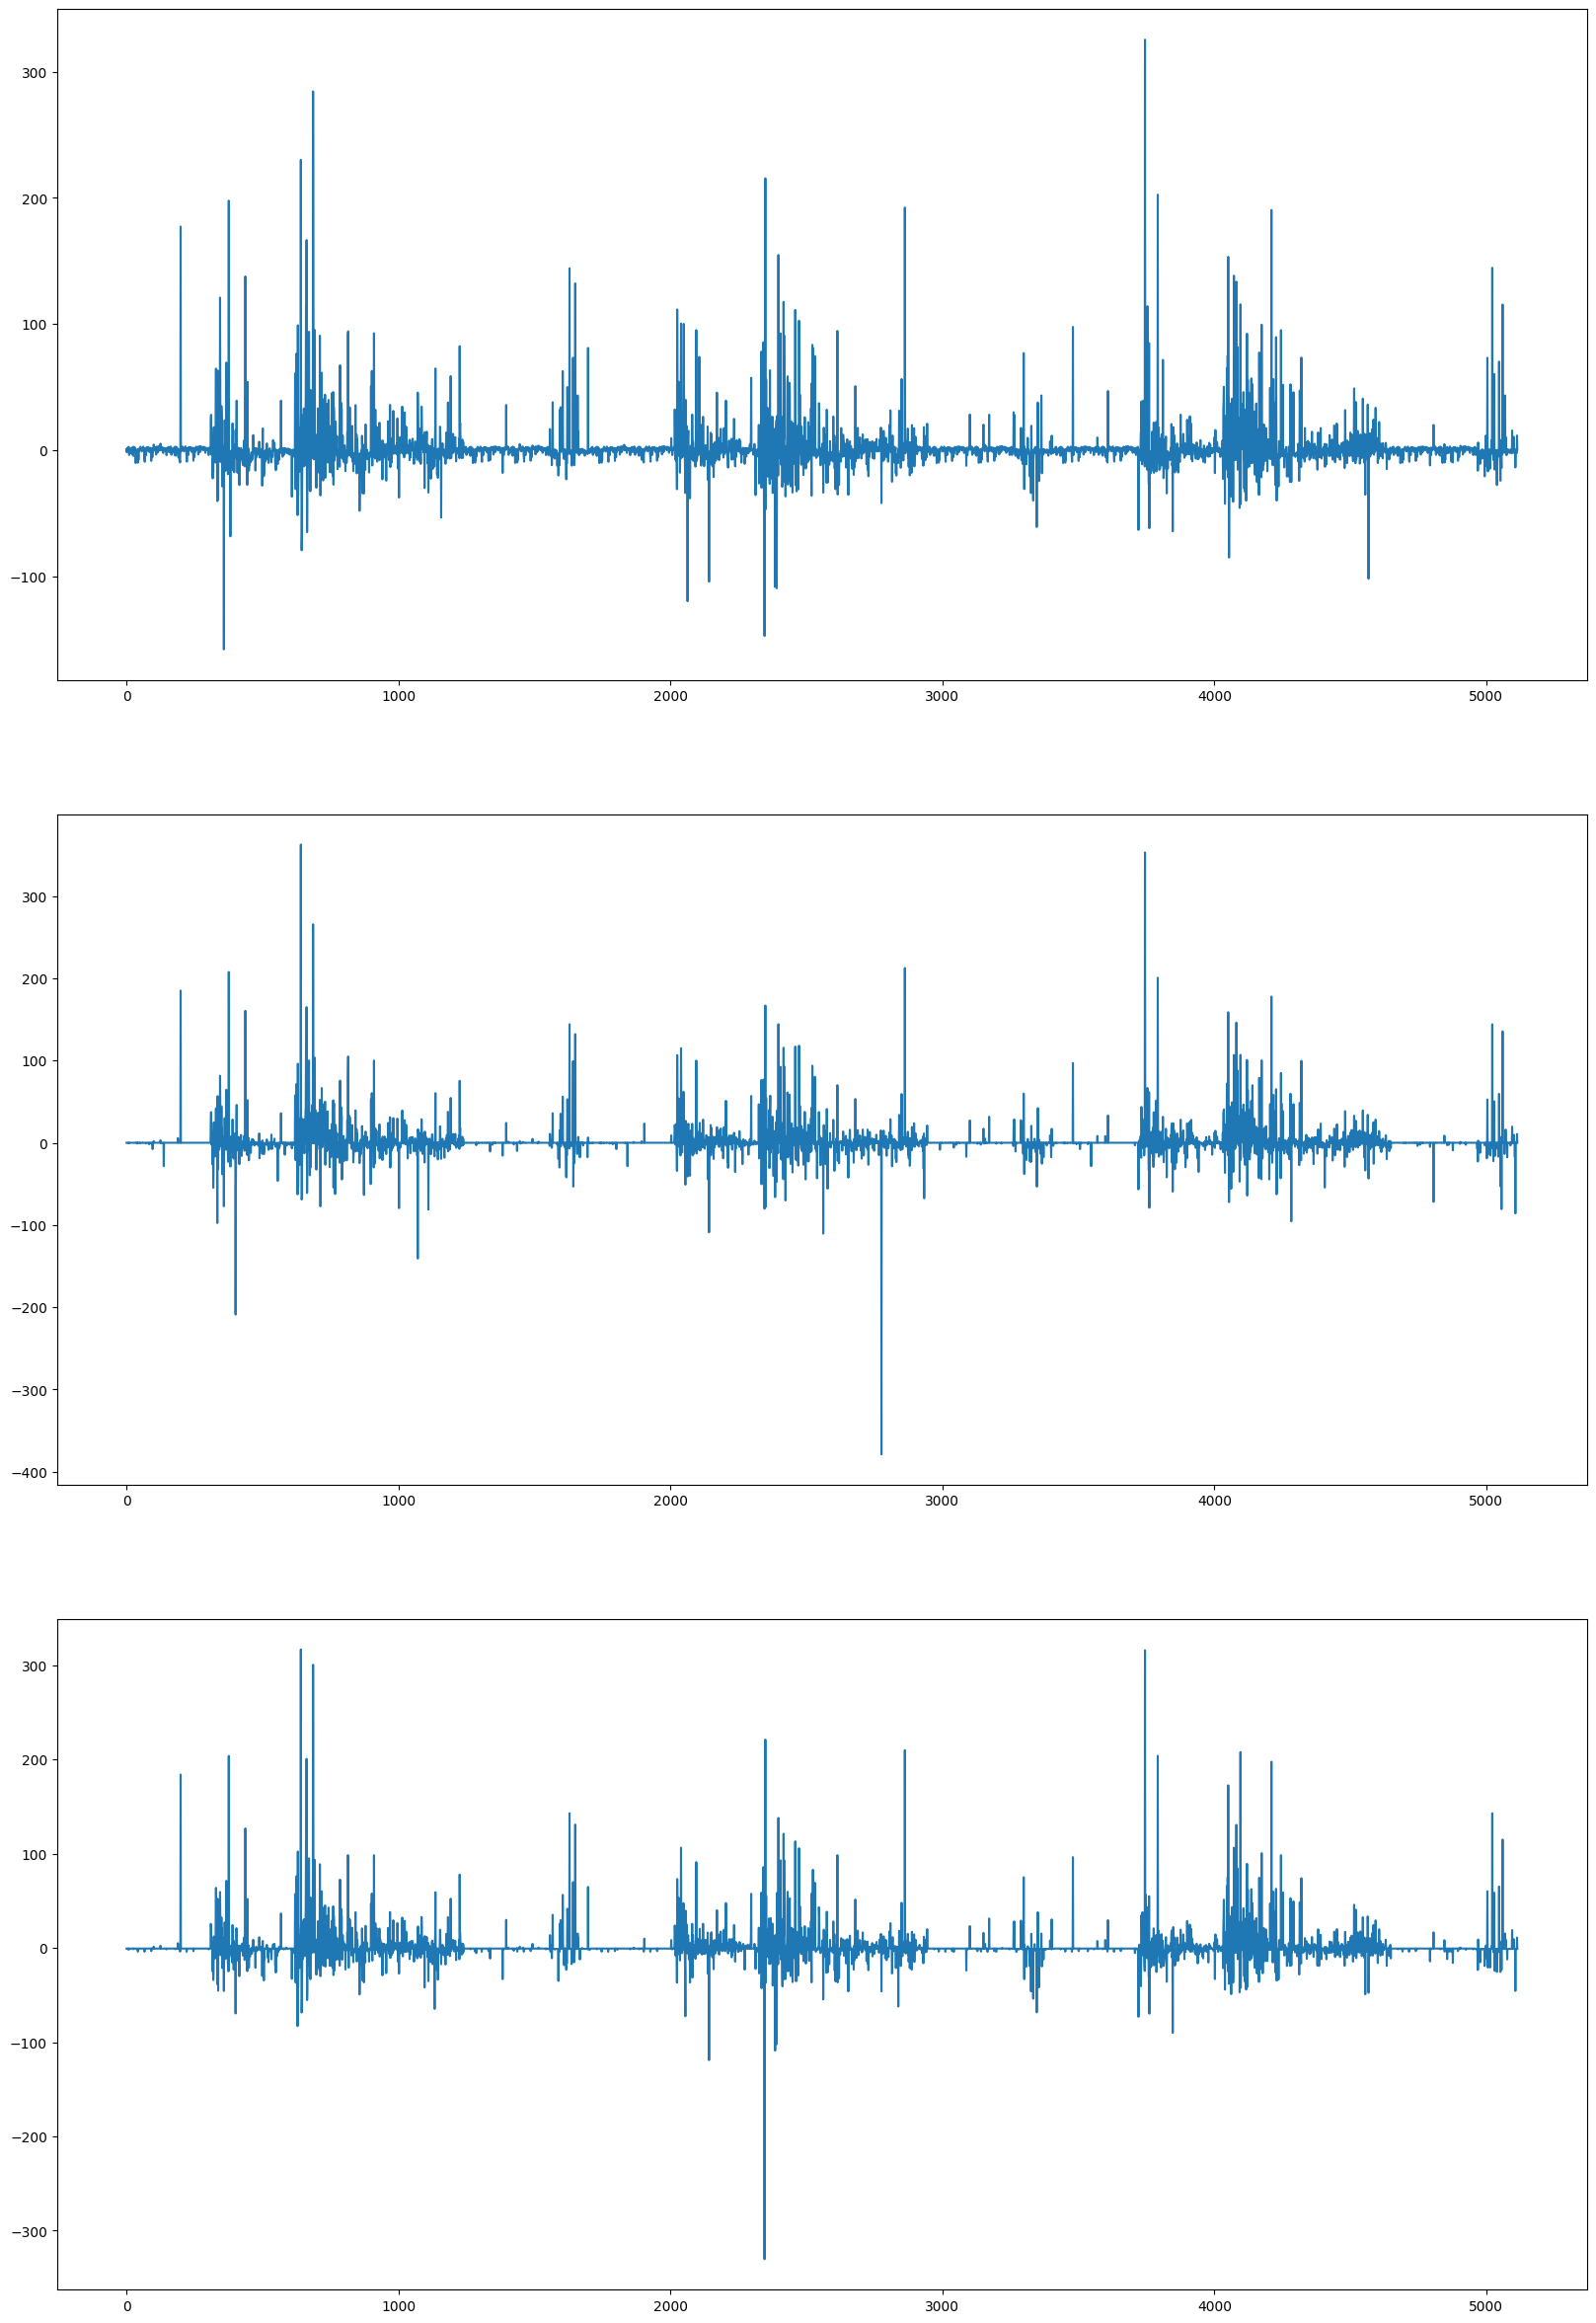

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 30))

for k, (name, model) in enumerate(models.items()):
        y_pred = model.predict(X_val)
        y_pred = np.where(y_pred<0, 0, y_pred)
        ax[k].plot(y_val["stock_distributed"].values-y_pred, label=name)


In [53]:
y_val['stock_distributed']-val['linreg_prediction']

66495     0.824395
66496    -2.695619
66497     0.639001
66498     1.621753
66499     0.554132
           ...    
71605    -0.855457
71606    -0.711859
71607    -3.298774
71608    11.843159
71609     0.313115
Length: 5115, dtype: float64